## Getting Started with Spins

Modeling spins often requires more involved 3D manipulations and visualizations, and this notebook gives an introduction to these capabilities in REBOUND/REBOUNDx.

In [1]:
import rebound
import reboundx
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

We consider a case of a hot Jupiter around an A-type star ($R_\odot \approx 5\times10^{-3} AU$, $R_J \approx 5\times10^{-4} AU$)

In [2]:
sim = rebound.Simulation()
sim.units = ('AU', 'Msun', 'yr')
sim.add(m=2, r=1e-2)
sim.add(m=3.e-3, r=5e-4, a=0.03)
ps = sim.particles

sim.integrator = "whfast"
sim.dt = ps[1].P/12 # timestep is a fraction of the orbital period
sim.move_to_com()

To model the spins (and add forces that cause them to evolve), we add `tides_spin` forces:

In [3]:
rebx = reboundx.Extras(sim)
sf = rebx.load_force("tides_spin")
rebx.add_force(sf)

To model the spins, we need to set the bodies' moments of inertia, and angular spin frequency vectors. To speed things up a bit, we assume rapid spin periods of 3 and half a day for the star and planet, respectively. 

We can set the spin vectors directly in Cartesian components, but often it's easier to think of these in terms of a magnitude for the angular spin frequency and two spherical angles: $\theta$ (from the $z$ axis) and azimuthal angle $\phi$ (from the $x$ axis). Since above we didn't set an inclination for the hot Jupiter orbit (so it defaults to 0), the $z$ axis is the orbit normal, so $\theta$ is just the obliquity for each body. We can do this easily by initializing a `rebound.reb_vec3d` from spherical coordinates. 

In [4]:
# Star parameters
star_spin = rebound.reb_vec3d.from_spherical(mag=2*np.pi/(3/365), theta=np.radians(60), phi=np.radians(30))
ps[0].params['sx'], ps[0].params['sy'], ps[0].params['sz'] = star_spin.x, star_spin.y, star_spin.z
ps[0].params['moi'] = 0.1 * ps[0].m * ps[0].r**2

# Planet parameters
planet_spin = rebound.reb_vec3d.from_spherical(mag=2*np.pi/(0.5/365), theta=np.radians(30), phi=0)
ps[1].params['sx'], ps[1].params['sy'], ps[1].params['sz'] = planet_spin.x, planet_spin.y, planet_spin.z
ps[1].params['moi'] = 0.25 * ps[1].m * ps[1].r**2

The next step is mandatory: to track the evolution of the spin axis, you MUST initialize the spin ODEs. Otherwise the spin axis will remain stationary and you won't see anything interesting!

In [5]:
rebx.initialize_spin_ode(sf)

Finally, in order for bodies to feel tides and deform from perfect spheres so that the spins will evolve, we additionally need to set their `k2` Love numbers. 

In [6]:
ps[0].params['k2'] = 0.1
ps[1].params['k2'] = 0.3

Now, we integrate. We'll track the planet and star spin vectors, as well as the orbit normal (planet's specific angular momentum vector):

In [7]:
#%%time
tmax = 4e4*ps[1].P
Nout = 1000
times = np.linspace(0, tmax, Nout)

splanet = np.zeros((Nout, 3))
sstar = np.zeros((Nout, 3))
orb = np.zeros((Nout, 3))
for i, t in enumerate(times):
    splanet[i] = [ps[1].params['sx'], ps[1].params['sy'], ps[1].params['sz']]
    sstar[i] = [ps[0].params['sx'], ps[0].params['sy'], ps[0].params['sz']]
    orb[i] = ps[1].hvec
    sim.integrate(t)

If we plot the planet's spin vector (sx, sy) over time, we see it's rather difficult to interpret:

Text(0, 0.5, 's_planet_y')

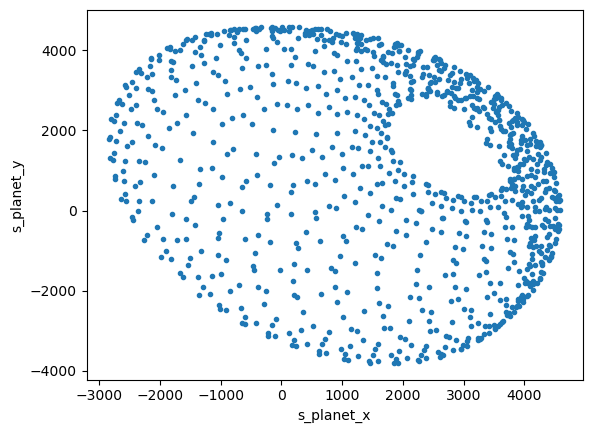

In [8]:
fig, ax = plt.subplots()
ax.plot(splanet[:,0], splanet[:,1], '.')
ax.set_xlabel('s_planet_x')
ax.set_ylabel('s_planet_y')

The problem is that the planet's spin vector wants to follow (precess around) its orbit normal. We initialized the orbit normal at $t=0$ to lie along the z axis, but we can check that by the end of the simulation, the orbit normal no longer points along the z direction:

In [9]:
orb[-1]

array([ 0.11959588, -0.17871103,  1.52511643])

In many cases, the orbital angular momentum completely dominates the spin angular momenta, so if we initialize the orbital angular momentum along $z$, we can reasonably expect it to stay there from angular momentum conservation. However, we've purposefully chosen an example where this is not the case and we have to work a bit harder.

We can check the angular momentum in the orbits using the regular REBOUND function:

In [10]:
sim.calculate_angular_momentum()

[0.00034600449571675445, -0.000519478845147151, 0.0045713024561709475]

However, REBOUND does not know about any REBOUNDx parameters (including spin). We can get the total angular momentum (including both orbital and spin angular momentum) with

In [11]:
rebx.calculate_total_angular_momentum()

[0.01146725196199124, 0.0066203906273059315, 0.012258893629184149]

We see that including the spin angular momenta substantially changes the total angular momentum, so we should expect it to significantly affect the orbital evolution. To investigate this, let's put all our simulation setup we used above into a single function:

In [12]:
import rebound
import reboundx
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
def setupsim():
    sim = rebound.Simulation()
    sim.units = ('AU', 'Msun', 'yr')
    sim.add(m=2, r=1e-2)
    sim.add(m=3.e-3, r=5e-4, a=0.03)
    ps = sim.particles

    sim.integrator = "whfast"
    sim.dt = ps[1].P/12 # timestep is a fraction of the orbital period
    sim.move_to_com()
    rebx = reboundx.Extras(sim)
    sf = rebx.load_force("tides_spin")
    rebx.add_force(sf)
    
    # Star parameters
    star_spin = rebound.reb_vec3d.from_spherical(mag=2*np.pi/(3/365), theta=np.radians(60), phi=np.radians(30))
    ps[0].params['sx'], ps[0].params['sy'], ps[0].params['sz'] = star_spin.x, star_spin.y, star_spin.z
    ps[0].params['moi'] = 0.1 * ps[0].m * ps[0].r**2
    ps[0].params['k2'] = 0.1
    
    # Planet parameters
    planet_spin = rebound.reb_vec3d.from_spherical(mag=2*np.pi/(0.5/365), theta=np.radians(30), phi=0)
    ps[1].params['sx'], ps[1].params['sy'], ps[1].params['sz'] = planet_spin.x, planet_spin.y, planet_spin.z
    ps[1].params['moi'] = 0.25 * ps[1].m * ps[1].r**2
    ps[1].params['k2'] = 0.3
    
    rebx.initialize_spin_ode(sf)
    return sim, rebx

Now let's choose our $z$ axis as the direction of the total angular momentum (i.e. use the invariable plane as the reference plane). This way the $z$ axis always has a fixed, physically relevant meaning. We can rotate our simulation to align with any given reference plane as below. `sim.rotate_simulation` only rotates the orbits however, so we also have to tell REBOUNDx to rotate any spatial params (in this case the spins):

In [13]:
sim, rebx = setupsim()
L = rebx.calculate_total_angular_momentum()
sim.rotate_simulation(normalvec=L)
rebx.rotate_params(normalvec=L)
ps = sim.particles

Given that we expect the planet spin vector to want to follow its orbit normal, let's see how we might track this evolution. Let's turn the planet spin into a `rebound.reb_vec3d` object to help us do our transformations:

In [14]:
pspin = rebound.reb_vec3d(ps[1].params['sx'], ps[1].params['sy'], ps[1].params['sz'])
pspin

<rebound.simulation.reb_vec3d object at 0x10f6a8b40, x=-1146.649068904046, y=1565.497978349053, z=4156.015006460948>

Recall that these 'sx', 'sy' and 'sz' values yield the spin vector referenced to the inertial reference frame (which we currently have lined up with the total angular momentum). If we want to calculate the planet spin vector relative to its orbital plane (with orbit normal `ps[1].hvec`), we can

In [15]:
pspinorb = pspin.rotate_XYZ_to_plane_xyz(normalvec=ps[1].hvec)

Our `pspinorb` is now a vector in a reference system where the $z$ axis lines up with the orbit normal (and $x$ along the orbit's ascending node in the invariable plane). The polar angle $\theta$ is thus the obliquity

In [16]:
obl = pspinorb.theta
np.degrees(obl)

30.000000000000004

To visualize the evolution, let's track the cartesian components of the star's spin and orbit normal relative to the invariable plane, and let's track the cartesian components of the planet's spin relative to its orbit normal (we can get the xyz components as `reb_vec3d.xyz`):

In [17]:
%%time
tmax = 4e4*ps[1].P
Nout = 1000
times = np.linspace(0, tmax, Nout)
ps = sim.particles

planetspins = np.zeros((Nout, 3))
starspins = np.zeros((Nout, 3))
hs = np.zeros((Nout, 3))
pspinorbs = np.zeros((Nout, 3))
obl, phi = np.zeros(Nout), np.zeros(Nout)
for i, t in enumerate(times):
    hs[i] = ps[1].hvec
    starspins[i] = [ps[0].params['sx'], ps[0].params['sy'], ps[0].params['sz']]
    
    pspin = rebound.reb_vec3d(ps[1].params['sx'], ps[1].params['sy'], ps[1].params['sz'])
    pspinorb = pspin.rotate_XYZ_to_plane_xyz(ps[1].hvec)
    pspinorbs[i] = pspinorb.xyz
    obl[i], phi[i] = pspinorb.theta, pspinorb.phi
    
    # If we instead formulate as functions:
    # pspinorbs[i] = rebound.rotate_XYZ_to_planet_xyz(planetspins[-1], normalvec=ps[1].hvec)
    # mag, obl[i], phi[i] = rebound.xyz_to_spherical(pspinorbs[i])
    sim.integrate(t)

CPU times: user 1 s, sys: 3.59 ms, total: 1.01 s
Wall time: 624 ms


Now if we plot the xy projection of the planet spin vector reference to its orbit normal, we see it executes a nearly perfect circle, i.e., it precesses around the orbit normal $z$ at constant obliquity. 

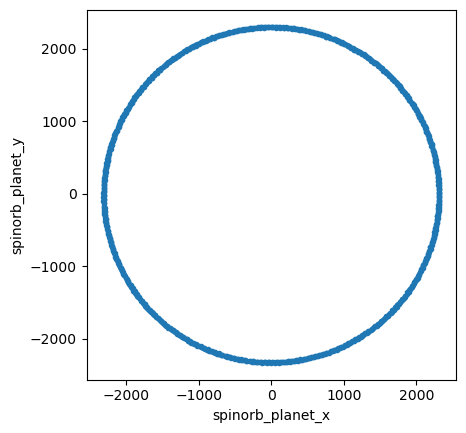

In [18]:
fig, ax = plt.subplots()
ax.plot(pspinorbs[:,0], pspinorbs[:,1], '.')
ax.set_xlabel('spinorb_planet_x')
ax.set_ylabel('spinorb_planet_y')
ax.set_aspect('equal')

It is often useful to visualize the evolution of these vectors in 3D. Here's a class that plots them in 3D (normalized to a passed `length`):

In [19]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.patches import FancyArrowPatch
from mpl_toolkits.mplot3d import proj3d

# Adapted from CTZhu and Ruli on https://stackoverflow.com/questions/22867620/putting-arrowheads-on-vectors-in-matplotlibs-3d-plot
default_arrow_props = dict(mutation_scale=20, arrowstyle='-|>', shrinkA=0, shrinkB=0)

class Arrow3D(FancyArrowPatch):
    def __init__(self, vec, c, length=1, *args, **kwargs):
        super().__init__((0,0), (0,0), color=c, *args, **default_arrow_props, **kwargs)
        vec = np.array(vec, dtype=float)
        vec *= length/np.linalg.norm(vec)

        self._verts3d = [0,vec[0]], [0,vec[1]], [0,vec[2]]

    def do_3d_projection(self, renderer=None):
        xs3d, ys3d, zs3d = self._verts3d
        xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, self.axes.M)
        self.set_positions((xs[0],ys[0]),(xs[1],ys[1]))

        return np.min(zs)

Let's first plot things in a frame that follows the orbit normal. We plot the orbit normal in red as a fixed vector along the $z$ axis. We then plot the planet spin vector in black over time (every 20 outputs). We see as above that the planet spin vector precesses at constant obliquity around the orbit normal.

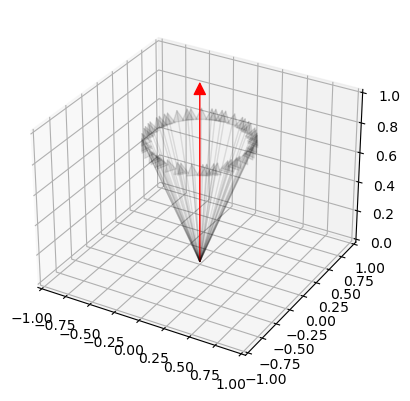

In [20]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_xlim([-1,1])
ax.set_ylim([-1,1])

a = Arrow3D([0,0,1], c='r', length=1.2)
ax.add_artist(a)
for i in range(0,len(starspins),20):
    a = Arrow3D(pspinorbs[i], c='k', alpha=0.1)
    ax.add_artist(a)

Now let's visualize what the orbit normal (red) and stellar spin vectors (blue) are doing in inertial space. We see that both are precessing at constant inclination around the total angular momentum (along $z$). The picture is thus the one below, with the planet's spin additionally sweeping out a cone around the red orbit normal as the latter undergoes its own rotation.

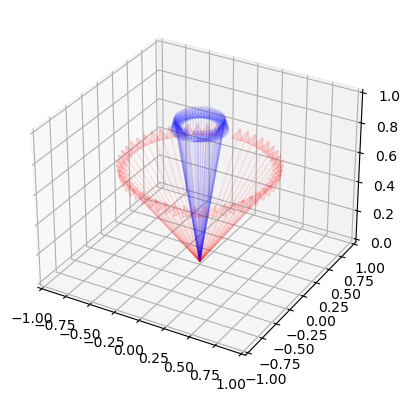

In [21]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_xlim([-1,1])
ax.set_ylim([-1,1])
for i in range(0,len(starspins),20):
    a = Arrow3D(starspins[i], c='b', alpha=0.1)
    b = Arrow3D(hs[i], c='r', alpha=0.1)
    ax.add_artist(a)
    ax.add_artist(b)

These rotation functions can also be helpful in more complicated cases where one wishes to initialize spins relative to inclined orbits.